In [436]:
import numpy as np
import matplotlib.pyplot as plt

`data.npz` contains data products from a 5G base-station.

* XYZ: (N_antenna, 2) cartesian antenna positions
* S: (N_slot, N_antenna, N_antenna) covariance matrices per time slot.
* T_slot: duration of a slot [s]
* lambda_: channel wavelength [m]
* src_model: (N_tx, 2) unit directions of transmitters in the cell area.

Communication systems process data at high throughput. As such it is difficult to capture long antenna traces.
Since throughput assessment via beamforming only requires solving positional inferance problems, we instead provide the (much) smaller covariance estimates between antennas per short time interval (1 [ms]).

In [437]:
path='data/data.npz'
df=np.load(path)
xyz=df['XYZ']
S=df['S']
T_slot=df['T_slot']
lambda_=df['lambda_']
src_model=df['src_model']

In [438]:
xyz.shape,S.shape,T_slot,lambda_,src_model.shape

((19, 2), (10000, 19, 19), array(0.001), array(0.33684546), (121, 2))

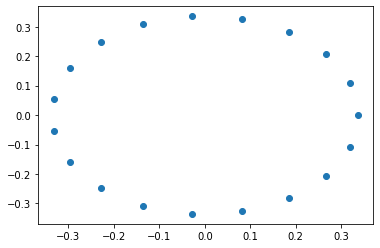

In [439]:
plt.scatter(xyz[:,0],xyz[:,1])
plt.show()

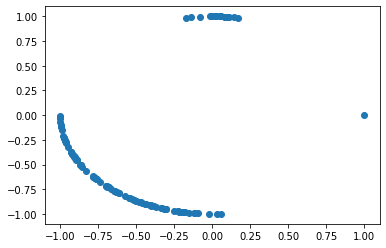

In [440]:
plt.scatter(src_model[:,0],src_model[:,1])
plt.show()

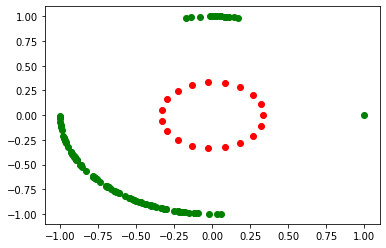

In [441]:
plt.plot(xyz[:,0],xyz[:,1],'ro',src_model[:,0],src_model[:,1], 'go')
plt.show()

In [442]:
signal=S[0]
signal.shape

(19, 19)

In [443]:
thetas=np.arange(0,360,0.1)
a=np.exp(-1j*2*np.pi/lambda_*(xyz@[np.cos(thetas*np.pi/180),np.sin(thetas*np.pi/180)])).reshape(19,-1)
a.shape,thetas.shape

((19, 3600), (3600,))

In [444]:
P=np.zeros(thetas.shape)
P.shape

(3600,)

In [445]:
J = np.flip(np.eye(19), axis=1)
signal=signal+np.dot(J,np.dot(signal.conj(),J))
signal.shape

(19, 19)

In [446]:
eigval,eigvect=np.linalg.eig(signal)
ids=np.abs(eigval).argsort()[:18]
En=eigvect[:,ids]
Ren=np.dot(En,En.conj().T)
Ren.shape

(19, 19)

In [447]:
eigval.argsort(),np.abs(eigval)

(array([12, 13, 16, 17, 18, 15, 14, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
         1,  0]),
 array([1113.20231749,  999.97816908,  825.71168503,  580.35662408,
         564.33677608,  453.01611125,  400.64986985,  312.24469831,
         256.75047997,  182.32027702,  155.12727002,  142.00165633,
         116.35603233,  118.02660385,  129.66654567,  128.59252703,
         121.16322352,  123.36445299,  123.5149708 ]))

In [448]:
for i in range(len(thetas)):
    P[i]=1/abs(np.dot(a[:,i].conj().T,np.dot(Ren,a[:,i])))

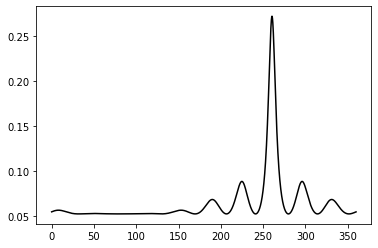

In [449]:
plt.plot(thetas,P,'-k')
plt.show()

In [450]:
index=P.argsort()[::-1]
index

array([2605, 2606, 2604, ..., 1695, 1696, 3515])

In [451]:
angle=thetas[index[0]]
angle

260.5

In [452]:
x,y=np.cos(angle*np.pi/180),np.sin(angle*np.pi/180)
x,y

(-0.16504760586067818, -0.9862856015372313)

In [453]:
src_model.shape

(121, 2)

In [454]:
res=[]
for xi,yi in src_model:
    res.append(np.sqrt((xi-x)**2+(yi-y)**2))

In [455]:
res=np.array(res)
res.argmin()

37

In [456]:
print(src_model[res.argmin()])

[-0.1515934  -0.98844294]


In [457]:
P=np.zeros(thetas.shape)
for i in range(len(thetas)):
    P[i]=abs(np.dot(a[:,i].conj().T,np.dot(signal,a[:,i])))
P=P/max(P)
P.shape

(3600,)

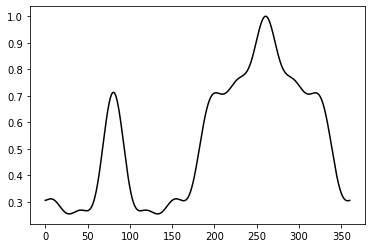

In [458]:
plt.plot(thetas,P,'-k')
plt.show()

In [459]:
index=P.argsort()[::-1]
angle=thetas[index[0]]
angle

260.5